In [293]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})  # Change 14 to your desired font size

# Also put tex font

plt.rcParams.update({'text.usetex': True, "font.family": "sans-serif",})

In [30]:
def count_subarrays_greater_than_threshold(arr, threshold=0.9):
    result = []
    current_length = 0
    
    for num in arr:
        if num > threshold:
            current_length += 1
        else:
            if current_length > 0:
                result.append(current_length)
                current_length = 0
    
    # Don't forget to check if we have a subarray at the end
    if current_length > 0:
        result.append(current_length)
    
    return result

In [244]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import os

def overlap_count(str1, str2):
    for i in range(min(len(str1), len(str2)), 0, -1):
        if str1[-i:] == str2[:i]:
            return i
    return 0

# Initialize an empty list to store data from all files
all_data = []

# Define experiment directory and mapping
experiments_base_path = '../experiments/'  # Replace with actual path
names_dataset = {
    'medicine': 'Drugs',
    'drugs': 'Drugs',
    'genetics': 'Genetics',
    'genetics-T06': 'Genetics', 
    'genetics-T05': 'Genetics', 
    'genetics-T04': 'Genetics', 
    'genetics-T03': 'Genetics', 
    'genetics-T02': 'Genetics', 
    'crypto': 'Cryptography', 
    # 'crypto-T06': 'Cryptography', 
    # 'crypto-T05': 'Cryptography', 
    # 'crypto-T04': 'Cryptography', 
    # 'crypto-T03': 'Cryptography', 
    # 'crypto-T02': 'Cryptography', 
    'nuclear': 'Nuclear physics'
}

n_windows_per_dataset = defaultdict(list)

# Function to load JSON files and extract data from Version 2 structure
for experiment_name in names_dataset.keys():
    experiment_dir = os.path.join(experiments_base_path, experiment_name)
    
    if not os.path.exists(experiment_dir):
        print(f"Warning: Experiment directory not found: {experiment_dir}")
        continue
    
    # Look for low perplexity region files
    regions_dir = os.path.join(experiment_dir, 'perplexity_analysis', 'low_perp_regions')
    
    if not os.path.exists(regions_dir):
        print(f"Warning: Regions directory not found: {regions_dir}")
        continue
    
    # Find all region files in this experiment
    region_files = glob.glob(os.path.join(regions_dir, 'prompt_*.json'))
    
    if not region_files:
        print(f"Warning: No region files found in: {regions_dir}")
        continue
    
    print(f"Processing experiment: {experiment_name} ({len(region_files)} files)")
    
    for region_file in region_files:
        try:
            # Load the region file
            with open(region_file, 'r', encoding='utf-8') as f:
                region_data = json.load(f)
            
            # Extract experiment metadata
            source_prompt_id = region_data.get('source_prompt_id', 'unknown')
            analysis_params = region_data.get('analysis_parameters', {})
            
            # Load corresponding generation file to get model info and prompt
            prompt_number = region_file.split('prompt_')[-1].split('_')[0].split('.')[0]
            generation_file = os.path.join(experiment_dir, 'inference_data', 'generations', f'prompt_{prompt_number}.json')
            
            generation_data = {}
            if os.path.exists(generation_file):
                with open(generation_file, 'r', encoding='utf-8') as f:
                    generation_data = json.load(f)
            
            # Extract model info and temperature
            model_info = generation_data.get('model_info', {})
            temperature = model_info.get('temperature', 0.7)
            model_name = model_info.get('model_name', 'unknown')
            
            # Check if this is a deduped experiment (based on experiment name or model info)
            deduped = 'deduped' in experiment_name or 'deduped' in model_name.lower()
            
            # Process each generation's regions
            for generation_regions in region_data.get('per_prompt_regions', []):
                generation_id = generation_regions.get('generation_id', 'unknown')
                
                for region in generation_regions.get('per_gen_regions', []):
                    # Extract text from tokens
                    region_text = ''.join(region.get('tokens', []))
                    
                    # Create a dictionary for each data point
                    data_point = {
                        'file': region_file,
                        'experiment_name': experiment_name,
                        'dataset': experiment_name,  # Will be mapped later
                        'prompt_id': source_prompt_id,
                        'generation_id': generation_id,
                        'region_id': region.get('region_id', 'unknown'),
                        'deduped': deduped,
                        'infinigram_count': region.get('infinigram_count', 0),
                        'standalone_perplexity': region['standalone_avg_perplexity'],
                        'perplexity': region.get('avg_perplexity', 0),
                        'min_perplexity': region.get('min_perplexity', 0),
                        'max_perplexity': region.get('max_perplexity', 0),
                        'text': region_text,
                        'temperature': temperature,
                        'model_name': model_name,
                        'in_prompt': region.get('is_in_prompt', False),
                        'is_contiguous': region.get('is_contiguous', True),
                        'start_index': region.get('start_index', 0),
                        'end_index': region.get('end_index', 0),
                        'infinigram_approx': region.get('infinigram_approx', False)
                    }
                    all_data.append(data_point)
            
            # Count windows for this dataset (if temperature is 0.7 and not deduped)
            if temperature == 0.7 and not deduped:
                # Count total regions for this file
                total_regions = sum(len(gen.get('per_gen_regions', [])) 
                                  for gen in region_data.get('per_prompt_regions', []))
                n_windows_per_dataset[names_dataset[experiment_name]].append(total_regions)
            
        except Exception as e:
            print(f"Error processing {region_file}: {e}")
            continue
    
    print(f"Processed {len([item for item in all_data if item['experiment_name'] == experiment_name])} regions from {experiment_name}")

# Create a pandas DataFrame from the collected data
df = pd.DataFrame(all_data)

if len(df) == 0:
    print("No data found! Check your experiment directories and file structure.")
else:
    # Map experiment names to display names
    df['dataset'] = df['dataset'].map(names_dataset)
    
    # Create adjusted infinigram count (for log plotting)
    df['infinigram_count_adj'] = df['infinigram_count'].copy()
    df.loc[df['infinigram_count_adj'] == 0, 'infinigram_count_adj'] = 0.3
    
    # Define regions based on the conditions
    def categorize(row):
        if row['infinigram_count_adj'] > 50:
            return "Frequently encountered text"
        elif 5 <= row['infinigram_count_adj'] <= 50:
            return "Segmental replication"
        elif 0.55 <= row['infinigram_count_adj'] <= 5:
            return "Memorization"
        elif row['infinigram_count_adj'] <= 0.55:
            return "Synthetic coherence"
        else:
            return "Other"
    
    # Apply the function to categorize each row
    df['category'] = df.apply(categorize, axis=1)
    
    # Create filtered datasets for analysis
    df_temperature = df[df['dataset'] == 'Genetics']
    
    # Filter main dataset (non-deduped, temperature 0.7)
    df_main = df[(df['deduped'] == False) & (df['temperature'] == 0.7)]
    
    # Display information about the combined dataset
    print("\nCombined Dataset Summary:")
    print(f"Total entries: {len(df)}")
    print(f"Unique datasets: {df['dataset'].unique()}")
    print(f"Unique experiments: {df['experiment_name'].unique()}")
    print(f"Temperature range: {df['temperature'].min():.1f} - {df['temperature'].max():.1f}")
    print(f"Models found: {df['model_name'].unique()}")
    print(f"Main filtered dataset (non-deduped, T=0.7): {len(df_main)} entries")
    print("\nDataset distribution:")
    print(df['dataset'].value_counts())
    print("\nCategory distribution:")
    print(df['category'].value_counts())
    print("\nSample of the data:")
    display(df.head())
    
    # Show infinigram statistics
    print(f"\nInfinigram Statistics:")
    print(f"Regions with infinigram_count > 0: {len(df[df['infinigram_count'] > 0])}")
    print(f"Regions with infinigram_count = 0: {len(df[df['infinigram_count'] == 0])}")
    print(f"Mean infinigram_count (excluding 0): {df[df['infinigram_count'] > 0]['infinigram_count'].mean():.2f}")
    print(f"Median infinigram_count (excluding 0): {df[df['infinigram_count'] > 0]['infinigram_count'].median():.2f}")

# Additional analysis helpers
print(f"\nExperiment directory structure found:")
for exp_name in names_dataset.keys():
    exp_dir = os.path.join(experiments_base_path, exp_name)
    if os.path.exists(exp_dir):
        regions_dir = os.path.join(exp_dir, 'perplexity_analysis', 'low_perp_regions')
        generations_dir = os.path.join(exp_dir, 'inference_data', 'generations')
        region_files = len(glob.glob(os.path.join(regions_dir, '*.json'))) if os.path.exists(regions_dir) else 0
        gen_files = len(glob.glob(os.path.join(generations_dir, '*.json'))) if os.path.exists(generations_dir) else 0
        print(f"  {exp_name}: {region_files} region files, {gen_files} generation files")
    else:
        print(f"  {exp_name}: NOT FOUND")

# Optional: Save processed data for future use
# df.to_csv('processed_experiment_data.csv', index=False)
# print("\nProcessed data saved to 'processed_experiment_data.csv'")

Processing experiment: medicine (40 files)
Processed 988 regions from medicine
Processing experiment: genetics (40 files)
Processed 1337 regions from genetics
Processing experiment: genetics-T06 (40 files)
Processed 1913 regions from genetics-T06
Processing experiment: genetics-T05 (40 files)
Processed 3297 regions from genetics-T05
Processing experiment: genetics-T04 (40 files)
Processed 4523 regions from genetics-T04
Processing experiment: genetics-T03 (40 files)
Processed 6127 regions from genetics-T03
Processing experiment: genetics-T02 (40 files)
Processed 8787 regions from genetics-T02
Processing experiment: crypto (40 files)
Processed 1336 regions from crypto
Processing experiment: nuclear (40 files)
Processed 1040 regions from nuclear


/tmp/ipykernel_31920/1444996600.py:149: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




Combined Dataset Summary:
Total entries: 29348
Unique datasets: ['Drugs' 'Genetics' 'Cryptography' 'Nuclear physics']
Unique experiments: ['medicine' 'genetics' 'genetics-T06' 'genetics-T05' 'genetics-T04'
 'genetics-T03' 'genetics-T02' 'crypto' 'nuclear']
Temperature range: 0.2 - 0.7
Models found: ['EleutherAI/pythia-6.9b']
Main filtered dataset (non-deduped, T=0.7): 4701 entries

Dataset distribution:
dataset
Genetics           25984
Cryptography        1336
Nuclear physics     1040
Drugs                988
Name: count, dtype: int64

Category distribution:
category
Synthetic coherence            19402
Frequently encountered text     3982
Segmental replication           3224
Memorization                    2740
Name: count, dtype: int64

Sample of the data:


,file,experiment_name,dataset,prompt_id,generation_id,region_id,deduped,infinigram_count,standalone_perplexity,perplexity,...,text,temperature,model_name,in_prompt,is_contiguous,start_index,end_index,infinigram_approx,infinigram_count_adj,category
0,../experiments/medicine/perplexity_analysis/lo...,medicine,Drugs,P0031,P0031_G00,P0031_G00_R01,False,530,3070.821188,1.0,...,", paracetamol is",0.7,EleutherAI/pythia-6.9b,False,False,48,54,False,530.0,Frequently encountered text
1,../experiments/medicine/perplexity_analysis/lo...,medicine,Drugs,P0031,P0031_G01,P0031_G01_R01,False,0,3651.257105,1.0,...,of paracetamol on,0.7,EleutherAI/pythia-6.9b,False,False,10,16,False,0.3,Synthetic coherence
2,../experiments/medicine/perplexity_analysis/lo...,medicine,Drugs,P0031,P0031_G01,P0031_G01_R02,False,0,91.743315,1.0,...,paracetamol on the,0.7,EleutherAI/pythia-6.9b,False,True,11,17,False,0.3,Synthetic coherence
3,../experiments/medicine/perplexity_analysis/lo...,medicine,Drugs,P0031,P0031_G01,P0031_G01_R03,False,105397,35.545708,1.0,...,"-1β, IL-",0.7,EleutherAI/pythia-6.9b,False,False,27,33,False,105397.0,Frequently encountered text
4,../experiments/medicine/perplexity_analysis/lo...,medicine,Drugs,P0031,P0031_G01,P0031_G01_R04,False,76580,472.866282,1.0,...,"1β, IL-6",0.7,EleutherAI/pythia-6.9b,False,True,28,34,False,76580.0,Frequently encountered text



Infinigram Statistics:
Regions with infinigram_count > 0: 9946
Regions with infinigram_count = 0: 19402
Mean infinigram_count (excluding 0): 42060.98
Median infinigram_count (excluding 0): 21.00

Experiment directory structure found:
  medicine: 40 region files, 40 generation files
  drugs: NOT FOUND
  genetics: 40 region files, 40 generation files
  genetics-T06: 40 region files, 40 generation files
  genetics-T05: 40 region files, 40 generation files
  genetics-T04: 40 region files, 40 generation files
  genetics-T03: 40 region files, 40 generation files
  genetics-T02: 40 region files, 40 generation files
  crypto: 40 region files, 40 generation files
  nuclear: 40 region files, 40 generation files


/tmp/ipykernel_31920/1039578185.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




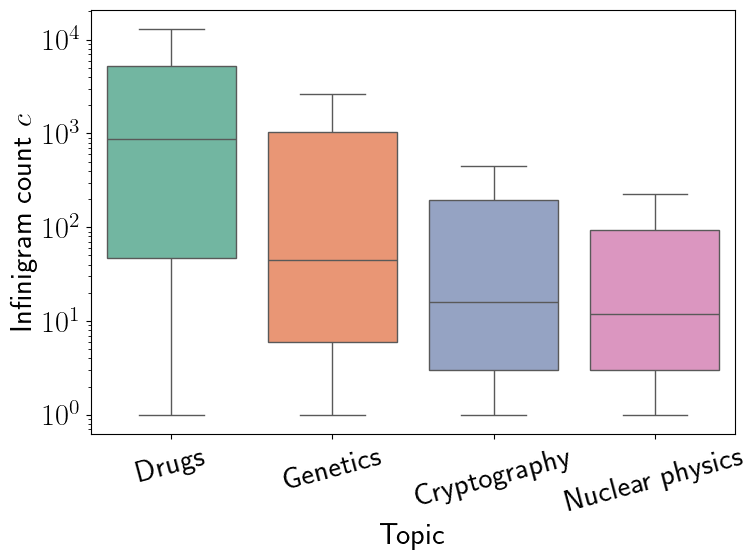

In [302]:
import seaborn as sns

# Create a figure with boxplots for each dataset and deduped combination
plt.figure(figsize=(8, 6))

# Create a boxplot for 'infinigram_count' grouped by 'dataset' and 'deduped'
sns.boxplot(data=df_main[df_main['infinigram_count'] > 0], x='dataset', y='infinigram_count', palette='Set2', showfliers=False)

# Add labels and title
plt.xlabel('Topic', fontsize=22)
plt.ylabel('Infinigram count $c$', fontsize=22)

plt.yscale('log')

# Rotate x-axis labels for better readability
plt.xticks(rotation=15)

plt.tick_params(axis='both', which='major', labelsize=22)

# Show the plot
plt.tight_layout()

plt.savefig('boxplot_datasets.png', dpi=300)

plt.show()


In [115]:
import pandas as pd
import numpy as np

# Extract region number from region_id
df['region_num'] = df['region_id'].str.extract(r'R(\d+)').astype(int)

# Sort by dataset, temperature, and region number to ensure proper ordering
df = df.sort_values(['dataset', 'temperature', 'region_num'])

# Group by dataset and temperature to process each separately
contiguous_lengths = []

for (dataset, temperature), group in df.groupby(['dataset', 'temperature']):
    dataset_df = group.copy()
    
    # Find contiguous sequences
    current_sequence = []
    sequences = []
    
    for idx, row in dataset_df.iterrows():
        if row['is_contiguous']:
            current_sequence.append(row['region_num'])
        else:
            # End current sequence if it exists
            if current_sequence:
                sequences.append(current_sequence)
                current_sequence = []
            # Single non-contiguous region
            sequences.append([row['region_num']])
    
    # Don't forget the last sequence if it ends with contiguous regions
    if current_sequence:
        sequences.append(current_sequence)
    
    # Calculate length for each sequence
    for seq in sequences:
        if len(seq) == 1:
            # Single region
            length = 6
        else:
            # Contiguous sequence: first region is 6, each additional adds 1
            length = 6 + (len(seq) - 1)
        
        contiguous_lengths.append({
            'dataset': dataset,
            'temperature': temperature,
            'sequence': seq,
            'length': length
        })

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(contiguous_lengths)

# Calculate statistics per dataset and temperature
stats_per_dataset_temp = results_df.groupby(['dataset', 'temperature'])['length'].agg(['mean', 'std', 'count']).reset_index()
stats_per_dataset_temp.columns = ['dataset', 'temperature', 'mean_length', 'std_length', 'num_sequences']

# Format the statistics with 0 digit rounding
stats_per_dataset_temp['mean_length'] = stats_per_dataset_temp['mean_length'].round(0)
stats_per_dataset_temp['std_length'] = stats_per_dataset_temp['std_length'].round(0)

print("Contiguous sequence lengths per dataset and temperature:")
print(stats_per_dataset_temp)

Contiguous sequence lengths per dataset and temperature:
           dataset  temperature  mean_length  std_length  num_sequences
0     Cryptography          0.7         10.0        14.0            270
1            Drugs          0.7          8.0         7.0            322
2         Genetics          0.2         12.0        25.0           1306
3         Genetics          0.3         11.0        26.0            984
4         Genetics          0.4         12.0        38.0            663
5         Genetics          0.5         12.0        27.0            476
6         Genetics          0.6         12.0        23.0            293
7         Genetics          0.7         11.0        19.0            212
8  Nuclear physics          0.7          9.0        10.0            262


In [61]:
# Filter the DataFrame for rows where infinigram_count is between 1 and 3
filtered_df = df[(df['infinigram_count'] >= 1) & (df['infinigram_count'] <= 3)]

# Sample a random row
random_sample = filtered_df.sample(n=1)

# Extract the text
sampled_text = random_sample.iloc[0]['text']

# Display the sampled text
print("Sampled Text:", sampled_text)

Sampled Text:  for studying the effects of a


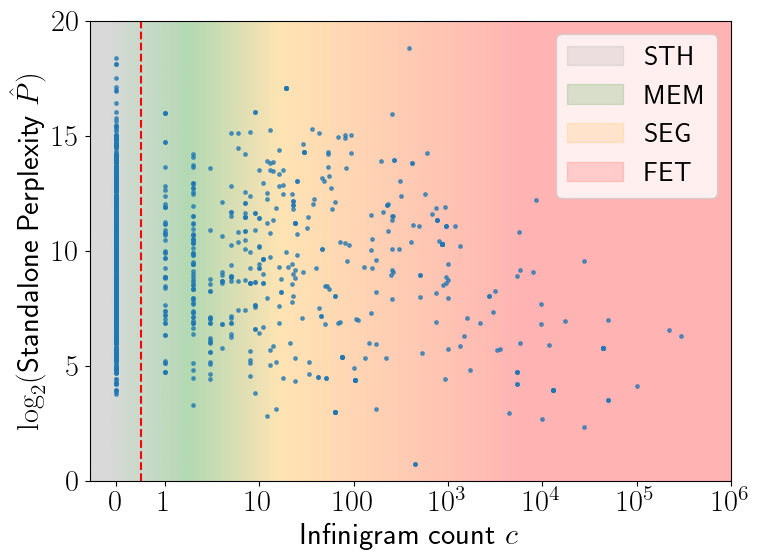

In [304]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.colors import cnames

dataset_name = 'Cryptography'

df_plot = df_main[df_main['dataset'] == dataset_name].copy()

# Original boundaries (log scale)
boundaries_log = np.array([0.1, 0.55, 5.5, 50, 1e6])
# Map boundaries to linear axis by taking log10
boundaries_linear = np.log10(boundaries_log)

# Colors and names for regions
region_colors = [cnames["gray"], cnames["green"], 'orange', 'red']
region_names = ['STH', 'MEM', 'SEG', 'FET']

# Centers of each region (in linear log space)
centers_linear = [(boundaries_linear[i] + boundaries_linear[i+1]) / 2 for i in range(len(boundaries_linear) - 1)]

# Normalize centers between 0 and 1 for colormap
positions = [(c - boundaries_linear[0]) / (boundaries_linear[-1] - boundaries_linear[0]) for c in centers_linear]

# Add 0 and 1 to positions and duplicate first/last colors to match colormap requirements
positions = [0.0] + positions + [1.0]
colors = [region_colors[0]] + region_colors + [region_colors[-1]]

# Create colormap with colors centered on regions
cmap = LinearSegmentedColormap.from_list("centered_gradient", list(zip(positions, colors)))

# Create gradient data (1 x N array)
n_points = 1000
x_linear = np.linspace(boundaries_linear[0], boundaries_linear[-1], n_points).reshape(1, -1)

# Generate scatter data: counts uniformly sampled in log space
np.random.seed(42)
x_counts = df_plot['infinigram_count_adj'].values
x_scatter = np.log10(x_counts)  # log10 transformed for linear axis

y_data = df_plot['standalone_perplexity'].apply(np.log2).values  # log2 transformed for y-axis

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Show gradient background, extent correctly ordered [xmin, xmax, ymin, ymax]
ax.imshow(x_linear, aspect='auto', cmap=cmap, alpha=0.3,
          extent=[boundaries_linear[0], boundaries_linear[-1], 0, 20], origin='lower')

# Scatter points on the same x-axis (log10 counts)
ax.scatter(x_scatter, y_data, s=6, alpha=0.7)

# Vertical line at log10(0.55)
ax.axvline(np.log10(0.55), color='r', linestyle='--')

# Axis limits (linear)
ax.set_xlim(-0.8, boundaries_linear[-1])
ax.set_ylim(0, 20)

ax.set_xlabel('Infinigram count $c$', fontsize=22)
ax.set_ylabel(r'$\log_2($Standalone Perplexity $\hat{P})$', fontsize=22)

# Custom ticks - original counts spaced by log10, but axis is linear
tick_vals = [0.3, 1, 10, 100, 1000, 10000, 100000, 1e6]
tick_pos = np.log10(tick_vals)
tick_labels = ['$0$' if val < 1 else f'${val:g}$' if val < 1000 else f'$10^{{{int(np.log10(val))}}}$' for val in tick_vals]

ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)

ax.tick_params(axis='both', which='major', labelsize=30)

# Legend patches with light transparency
legend_patches = [Patch(color=c, alpha=0.15, label=l) for c, l in zip(region_colors, region_names)]
ax.legend(handles=legend_patches)

plt.tight_layout()

plt.savefig(f'{dataset_name}_scatter.png')
plt.show()


In [121]:
result = df_main.groupby('dataset').agg(
    avg_perplexity=('perplexity', 'mean'),
    total_low_perplexity_regions=('perplexity', 'count'),
    non_zero_counts=('infinigram_count', lambda x: (x > 0).sum()),
    in_prompt_ratio=('in_prompt', lambda x: f"{(100 * x.sum() / len(x)):.2g}\%")
).reset_index()  # Reset index to make 'dataset' a column
n_windows_stats = {k: {'avg': np.mean(v), 'std': np.std(v)} for k, v in n_windows_per_dataset.items()}

# Add n_windows_avg and n_windows_std columns to the result DataFrame
result['n_windows_avg'] = result['dataset'].map(lambda x: n_windows_stats.get(x, {}).get('avg', np.nan))
result['n_windows_std'] = result['dataset'].map(lambda x: n_windows_stats.get(x, {}).get('std', np.nan))

# Calculate percentage of non-zero counts
result['non_zero_percent'] = (result['non_zero_counts'] / result['total_low_perplexity_regions'] * 100).map('{:.2g}\\%'.format)

# Reorder columns
result = result[['dataset', 'total_low_perplexity_regions', 'non_zero_counts', 'non_zero_percent', 'in_prompt_ratio']]

# Add a row for all datasets combined
all_datasets_row = {
    'dataset': 'Total',
    'total_low_perplexity_regions': result['total_low_perplexity_regions'].sum(),
    'non_zero_counts': result['non_zero_counts'].sum(),
    'non_zero_percent': f"{(result['non_zero_counts'].sum() / result['total_low_perplexity_regions'].sum() * 100):.2g}\\%",
    'in_prompt_ratio': f"{(result['in_prompt_ratio'].str.rstrip('\\%').astype(float).mean()):.2g}\\%",
}

# Append the row to the result DataFrame
result = pd.concat([result, pd.DataFrame([all_datasets_row])], ignore_index=True)

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{lrrll}
\toprule
dataset & total_low_perplexity_regions & non_zero_counts & non_zero_percent & in_prompt_ratio \\
\midrule
Cryptography & 1336 & 505 & 38\% & 32\% \\
Drugs & 988 & 659 & 67\% & 7.9\% \\
Genetics & 1337 & 481 & 36\% & 29\% \\
Nuclear physics & 1040 & 264 & 25\% & 15\% \\
Total & 4701 & 1909 & 41\% & 21\% \\
\bottomrule
\end{tabular}



<>:5: SyntaxWarning:

invalid escape sequence '\%'

<>:5: SyntaxWarning:

invalid escape sequence '\%'

/tmp/ipykernel_31920/163357879.py:5: SyntaxWarning:

invalid escape sequence '\%'



In [99]:
# Filter the DataFrame for rows where infinigram_count > 0
filtered_df = df[df['infinigram_count'] > 0]

# Group by dataset and calculate the ratio of in_prompt=True
in_prompt_ratio = filtered_df.groupby('dataset')['in_prompt'].mean()

# Print the results
print(in_prompt_ratio)

dataset
Cryptography       0.170088
Drugs              0.083460
Genetics           0.135135
Nuclear physics    0.053030
Name: in_prompt, dtype: float64


In [123]:
result = df_main.groupby(['category', 'dataset']).agg(
    total_low_perplexity_regions=('perplexity', 'count')).reset_index('category')

# Reset index to make dataset a column
result = result.reset_index()
result = result.pivot(index='dataset', columns='category', values='total_low_perplexity_regions')
result.columns.name = None
result = result.div(result.sum(axis=1), axis=0) * 100
result = result[['Synthetic coherence','Memorization','Segmental replication','Frequently encountered text',]].map('{:.2g}\\%'.format)

# Set float format to 2 significant digits
print(result.to_latex(index=True, float_format="%.2g"))

\begin{tabular}{lllll}
\toprule
 & Synthetic coherence & Memorization & Segmental replication & Frequently encountered text \\
dataset &  &  &  &  \\
\midrule
Cryptography & 62\% & 11\% & 13\% & 14\% \\
Drugs & 33\% & 7.5\% & 9.3\% & 50\% \\
Genetics & 64\% & 7.7\% & 11\% & 17\% \\
Nuclear physics & 75\% & 8.1\% & 9.3\% & 8\% \\
\bottomrule
\end{tabular}



In [246]:
result = df_temperature.groupby(['category', 'temperature']).agg(
    total_low_perplexity_regions=('perplexity', 'count')).reset_index('category')

# Reset index to make dataset a column
result = result.reset_index()
result = result.pivot(index='temperature', columns='category', values='total_low_perplexity_regions')
result.columns.name = None
result = result.div(result.sum(axis=1), axis=0) * 100
result.reset_index(inplace=True)

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{rrrrr}
\toprule
temperature & Frequently encountered text & Memorization & Segmental replication & Synthetic coherence \\
\midrule
0.2 & 13 & 9.7 & 11 & 67 \\
0.3 & 12 & 9 & 11 & 69 \\
0.4 & 11 & 9.5 & 12 & 68 \\
0.5 & 13 & 10 & 9.6 & 67 \\
0.6 & 13 & 8.4 & 13 & 66 \\
0.7 & 17 & 7.7 & 11 & 64 \\
\bottomrule
\end{tabular}



In [245]:
result = df_temperature.groupby('temperature').agg(
    avg_perplexity=('standalone_perplexity', lambda x: f"{np.log(x.mean()):.2g}"),
    total_low_perplexity_regions=('perplexity', 'count'),
    non_zero_counts=('infinigram_count', lambda x: (x > 0).sum()),
    in_prompt_ratio=('in_prompt', lambda x: f"{(x.sum()):.0f}")
)

# Calculate percentage of non-zero counts
result['non_zero_percent'] = (result['non_zero_counts'] / result['total_low_perplexity_regions'] * 100).map('{:.2g}\\%'.format)

# Reorder columns
result= result.reset_index()
result = result[['temperature', 'total_low_perplexity_regions', 'non_zero_counts', 'non_zero_percent', 'in_prompt_ratio', 'avg_perplexity']]

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{rrrlll}
\toprule
temperature & total_low_perplexity_regions & non_zero_counts & non_zero_percent & in_prompt_ratio & avg_perplexity \\
\midrule
0.2 & 8787 & 2908 & 33\% & 743 & 8.7 \\
0.3 & 6127 & 1918 & 31\% & 589 & 8.5 \\
0.4 & 4523 & 1461 & 32\% & 598 & 8.9 \\
0.5 & 3297 & 1091 & 33\% & 560 & 8.8 \\
0.6 & 1913 & 659 & 34\% & 310 & 8.6 \\
0.7 & 1337 & 481 & 36\% & 386 & 8.5 \\
\bottomrule
\end{tabular}



In [213]:
y_data

array([ 3070.8211877 ,  3651.2571054 ,    91.74331495, ...,
       32656.26230702, 31910.04284539, 53602.01944021])

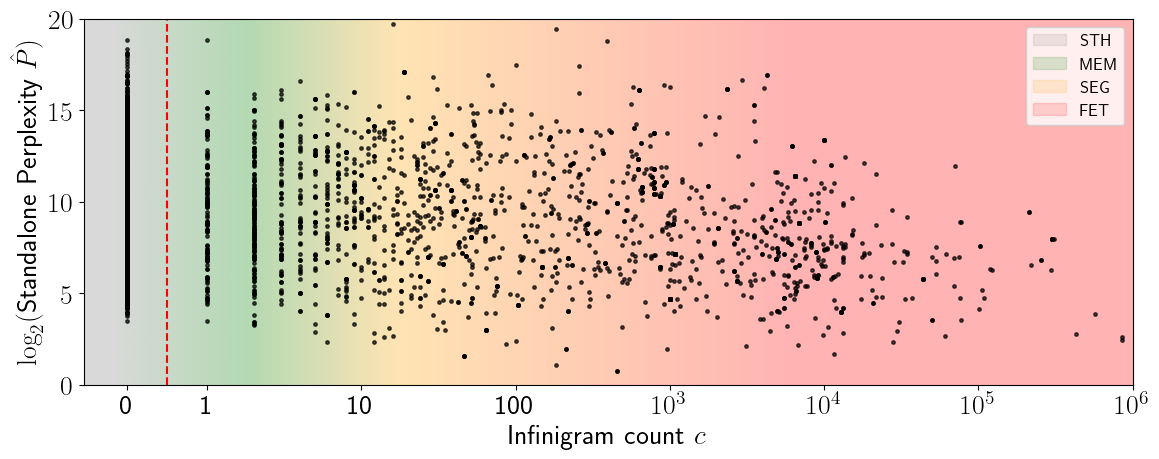

In [237]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from matplotlib.colors import cnames

# Original boundaries (log scale)
boundaries_log = np.array([0.1, 0.55, 5.5, 50, 1e6])
# Map boundaries to linear axis by taking log10
boundaries_linear = np.log10(boundaries_log)

# Colors and names for regions
region_colors = [cnames["gray"], cnames["green"], 'orange', 'red']
region_names = ['STH', 'MEM', 'SEG', 'FET']

# Centers of each region (in linear log space)
centers_linear = [(boundaries_linear[i] + boundaries_linear[i+1]) / 2 for i in range(len(boundaries_linear) - 1)]

# Normalize centers between 0 and 1 for colormap
positions = [(c - boundaries_linear[0]) / (boundaries_linear[-1] - boundaries_linear[0]) for c in centers_linear]

# Add 0 and 1 to positions and duplicate first/last colors to match colormap requirements
positions = [0.0] + positions + [1.0]
colors = [region_colors[0]] + region_colors + [region_colors[-1]]

# Create colormap with colors centered on regions
cmap = LinearSegmentedColormap.from_list("centered_gradient", list(zip(positions, colors)))

# Create gradient data (1 x N array)
n_points = 1000
x_linear = np.linspace(boundaries_linear[0], boundaries_linear[-1], n_points).reshape(1, -1)

# Generate scatter data: counts uniformly sampled in log space
np.random.seed(42)
x_counts = df_main['infinigram_count_adj'].values
x_scatter = np.log10(x_counts)  # log10 transformed for linear axis

y_data = df_main['standalone_perplexity'].apply(np.log2).values  # log2 transformed for y-axis

# Plot
fig, ax = plt.subplots(figsize=(12, 5))

# Show gradient background, extent correctly ordered [xmin, xmax, ymin, ymax]
ax.imshow(x_linear, aspect='auto', cmap=cmap, alpha=0.3,
          extent=[boundaries_linear[0], boundaries_linear[-1], 0, 20], origin='lower')

# Scatter points on the same x-axis (log10 counts)
ax.scatter(x_scatter, y_data, s=6, alpha=0.7, color='black')

# Vertical line at log10(0.55)
ax.axvline(np.log10(0.55), color='r', linestyle='--')

# Axis limits (linear)
ax.set_xlim(-0.8, boundaries_linear[-1])
ax.set_ylim(0, 20)

ax.set_xlabel('Infinigram count $c$')
ax.set_ylabel(r'$\log_2($Standalone Perplexity $\hat{P})$')

# Custom ticks - original counts spaced by log10, but axis is linear
tick_vals = [0.3, 1, 10, 100, 1000, 10000, 100000, 1e6]
tick_pos = np.log10(tick_vals)
tick_labels = ['0' if val < 1 else f'{val:g}' if val < 1000 else f'$10^{{{int(np.log10(val))}}}$' for val in tick_vals]

ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)

# Legend patches with light transparency
legend_patches = [Patch(color=c, alpha=0.15, label=l) for c, l in zip(region_colors, region_names)]
ax.legend(handles=legend_patches, fontsize=12)

plt.tight_layout()
plt.show()


In [129]:
import plotly.express as px

# Filter the DataFrame for the "cyber" dataset

# Create a scatter plot
fig = px.scatter(df[df['dataset'] == 'Drugs'], x='infinigram_count_adj', y='standalone_perplexity', color='deduped',
                 title='Scatter Plot of Infinigram Count vs Perplexity for All Dataset',
                 labels={'infinigram_count': 'Infinigram Count', 'perplexity': 'Perplexity'},
                 hover_data=['text'])

fig.update_xaxes(type='log')
fig.update_yaxes(type='log')

fig.update_layout({'width': 1200, 'height': 800})

# Show the plot
fig.show()

In [252]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import glob
import os
import sys

def overlap_count(str1, str2):
    for i in range(min(len(str1), len(str2)), 0, -1):
        if str1[-i:] == str2[:i]:
            return i
    return 0

# Initialize an empty list to store data from all files
all_data = []

# Define experiment directory and mapping
experiments_base_path = '../experiments/sizes/*'  # Replace with actual path

n_windows_per_dataset = defaultdict(list)

# Function to load JSON files and extract data from Version 2 structure
for experiment_dir in glob.glob(experiments_base_path):
    experiment_name = os.path.basename(experiment_dir)
    
    if not os.path.exists(experiment_dir):
        print(f"Warning: Experiment directory not found: {experiment_dir}")
        continue
    
    # Look for low perplexity region files
    regions_dir = os.path.join(experiment_dir, 'perplexity_analysis', 'low_perp_regions')
    
    if not os.path.exists(regions_dir):
        print(f"Warning: Regions directory not found: {regions_dir}")
        continue
    
    # Find all region files in this experiment
    region_files = glob.glob(os.path.join(regions_dir, 'prompt_*.json'))
    
    if not region_files:
        print(f"Warning: No region files found in: {regions_dir}")
        continue
    
    print(f"Processing experiment: {experiment_name} ({len(region_files)} files)")
    
    for region_file in region_files:
        try:
            # Load the region file
            with open(region_file, 'r', encoding='utf-8') as f:
                region_data = json.load(f)
                
            # Extract experiment metadata
            source_prompt_id = region_data.get('source_prompt_id', 'unknown')
            analysis_params = region_data.get('analysis_parameters', {})
            
            # Load corresponding generation file to get model info and prompt
            prompt_number = region_file.split('prompt_')[-1].split('_')[0].split('.')[0]
            generation_file = os.path.join(experiment_dir, 'inference_data', 'generations', f'prompt_{prompt_number}.json')
            
            generation_data = {}
            if os.path.exists(generation_file):
                with open(generation_file, 'r', encoding='utf-8') as f:
                    generation_data = json.load(f)
            
            # Extract model info and temperature
            model_info = generation_data.get('model_info', {})
            temperature = model_info.get('temperature', 0.7)
            model_name = model_info.get('model_name', 'unknown')
            
            # Check if this is a deduped experiment (based on experiment name or model info)
            deduped = 'deduped' in experiment_name or 'deduped' in model_name.lower()
            
            # Process each generation's regions
            for generation_regions in region_data.get('per_prompt_regions', []):
                generation_id = generation_regions.get('generation_id', 'unknown')
                
                for region in generation_regions.get('per_gen_regions', []):
                    # Extract text from tokens
                    region_text = ''.join(region.get('tokens', []))
                    
                    # Create a dictionary for each data point
                    data_point = {
                        'file': region_file,
                        'experiment_name': experiment_name,
                        'dataset': experiment_name,  # Will be mapped later
                        'prompt_id': source_prompt_id,
                        'generation_id': generation_id,
                        'region_id': region.get('region_id', 'unknown'),
                        'deduped': deduped,
                        'infinigram_count': region.get('infinigram_count', 0),
                        'standalone_perplexity': region['standalone_avg_perplexity'],
                        'perplexity': region.get('avg_perplexity', 0),
                        'min_perplexity': region.get('min_perplexity', 0),
                        'max_perplexity': region.get('max_perplexity', 0),
                        'text': region_text,
                        'temperature': temperature,
                        'model_name': model_name,
                        'in_prompt': region.get('is_in_prompt', False),
                        'is_contiguous': region.get('is_contiguous', True),
                        'start_index': region.get('start_index', 0),
                        'end_index': region.get('end_index', 0),
                        'infinigram_approx': region.get('infinigram_approx', False)
                    }
                    all_data.append(data_point)
            # Count windows for this dataset (if temperature is 0.7 and not deduped)
            if temperature == 0.7 and not deduped:
                # Count total regions for this file
                total_regions = sum(len(gen.get('per_gen_regions', [])) 
                                  for gen in region_data.get('per_prompt_regions', []))
                n_windows_per_dataset[experiment_name].append(total_regions)
            
        except Exception as e:
            print(f"Error processing {region_file}: {e}")
            continue
    
    print(f"Processed {len([item for item in all_data if item['experiment_name'] == experiment_name])} regions from {experiment_name}")

# Create a pandas DataFrame from the collected data
df_sizes = pd.DataFrame(all_data)

if len(df_sizes) == 0:
    print("No data found! Check your experiment directories and file structure.")
else:    
    # Create adjusted infinigram count (for log plotting)
    df_sizes['infinigram_count_adj'] = df_sizes['infinigram_count'].copy()
    df_sizes.loc[df_sizes['infinigram_count_adj'] == 0, 'infinigram_count_adj'] = 0.3
    
    # Define regions based on the conditions
    def categorize(row):
        if row['infinigram_count_adj'] > 50:
            return "Frequently encountered text"
        elif 5 <= row['infinigram_count_adj'] <= 50:
            return "Segmental replication"
        elif 0.55 <= row['infinigram_count_adj'] <= 5:
            return "Memorization"
        elif row['infinigram_count_adj'] <= 0.55:
            return "Synthetic coherence"
        else:
            return "Other"
    
    # Apply the function to categorize each row
    df_sizes['category'] = df_sizes.apply(categorize, axis=1)
    
    # Create filtered datasets for analysis
    df_sizes_temperature = df_sizes[df_sizes['dataset'] == 'Genetics']
    
    # Filter main dataset (non-deduped, temperature 0.7)
    df_sizes_main = df_sizes[(df_sizes['deduped'] == False) & (df_sizes['temperature'] == 0.7)]
    
    # Display information about the combined dataset
    print("\nCombined Dataset Summary:")
    print(f"Total entries: {len(df_sizes)}")
    print(f"Unique datasets: {df_sizes['dataset'].unique()}")
    print(f"Unique experiments: {df_sizes['experiment_name'].unique()}")
    print(f"Temperature range: {df_sizes['temperature'].min():.1f} - {df_sizes['temperature'].max():.1f}")
    print(f"Models found: {df_sizes['model_name'].unique()}")
    print(f"Main filtered dataset (non-deduped, T=0.7): {len(df_sizes_main)} entries")
    print("\nDataset distribution:")
    print(df_sizes['dataset'].value_counts())
    print("\nCategory distribution:")
    print(df_sizes['category'].value_counts())
    print("\nSample of the data:")
    display(df_sizes.head())
    
    # Show infinigram statistics
    print(f"\nInfinigram Statistics:")
    print(f"Regions with infinigram_count > 0: {len(df_sizes[df_sizes['infinigram_count'] > 0])}")
    print(f"Regions with infinigram_count = 0: {len(df_sizes[df_sizes['infinigram_count'] == 0])}")
    print(f"Mean infinigram_count (excluding 0): {df_sizes[df_sizes['infinigram_count'] > 0]['infinigram_count'].mean():.2f}")
    print(f"Median infinigram_count (excluding 0): {df_sizes[df_sizes['infinigram_count'] > 0]['infinigram_count'].median():.2f}")

# Additional analysis helpers
print(f"\nExperiment directory structure found:")
for exp_name in names_dataset.keys():
    exp_dir = os.path.join(experiments_base_path, exp_name)
    if os.path.exists(exp_dir):
        regions_dir = os.path.join(exp_dir, 'perplexity_analysis', 'low_perp_regions')
        generations_dir = os.path.join(exp_dir, 'inference_data', 'generations')
        region_files = len(glob.glob(os.path.join(regions_dir, '*.json'))) if os.path.exists(regions_dir) else 0
        gen_files = len(glob.glob(os.path.join(generations_dir, '*.json'))) if os.path.exists(generations_dir) else 0
        print(f"  {exp_name}: {region_files} region files, {gen_files} generation files")
    else:
        print(f"  {exp_name}: NOT FOUND")

# Optional: Save processed data for future use
# df_sizes.to_csv('processed_experiment_data.csv', index=False)
# print("\nProcessed data saved to 'processed_experiment_data.csv'")

Processing experiment: genetics-160m (72 files)
Processed 3676 regions from genetics-160m
Processing experiment: genetics-1.4b (75 files)
Processed 2123 regions from genetics-1.4b
Processing experiment: genetics-2.8b (51 files)
Processed 1714 regions from genetics-2.8b
Processing experiment: genetics-410m (65 files)
Processed 2274 regions from genetics-410m
Processing experiment: genetics-1b (80 files)
Processed 2766 regions from genetics-1b
Processing experiment: genetics-70m (80 files)
Processed 8548 regions from genetics-70m


/tmp/ipykernel_31920/1851175698.py:129: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.




Combined Dataset Summary:
Total entries: 21101
Unique datasets: ['genetics-160m' 'genetics-1.4b' 'genetics-2.8b' 'genetics-410m'
 'genetics-1b' 'genetics-70m']
Unique experiments: ['genetics-160m' 'genetics-1.4b' 'genetics-2.8b' 'genetics-410m'
 'genetics-1b' 'genetics-70m']
Temperature range: 0.7 - 0.7
Models found: ['EleutherAI/pythia-160m' 'EleutherAI/pythia-1.4b'
 'EleutherAI/pythia-2.8b' 'EleutherAI/pythia-410m' 'EleutherAI/pythia-1b'
 'EleutherAI/pythia-70m']
Main filtered dataset (non-deduped, T=0.7): 21101 entries

Dataset distribution:
dataset
genetics-70m     8548
genetics-160m    3676
genetics-1b      2766
genetics-410m    2274
genetics-1.4b    2123
genetics-2.8b    1714
Name: count, dtype: int64

Category distribution:
category
Synthetic coherence            14166
Frequently encountered text     2742
Segmental replication           2173
Memorization                    2020
Name: count, dtype: int64

Sample of the data:


,file,experiment_name,dataset,prompt_id,generation_id,region_id,deduped,infinigram_count,standalone_perplexity,perplexity,...,text,temperature,model_name,in_prompt,is_contiguous,start_index,end_index,infinigram_approx,infinigram_count_adj,category
0,../experiments/sizes/genetics-160m/perplexity_...,genetics-160m,genetics-160m,P0064,P0064_G00,P0064_G00_R01,False,0,295.207913,1.0,...,genetic diversity of a population is,0.7,EleutherAI/pythia-160m,False,False,66,72,False,0.3,Synthetic coherence
1,../experiments/sizes/genetics-160m/perplexity_...,genetics-160m,genetics-160m,P0064,P0064_G00,P0064_G00_R02,False,0,50.004492,1.0,...,trait at a given time.,0.7,EleutherAI/pythia-160m,False,False,82,88,False,0.3,Synthetic coherence
2,../experiments/sizes/genetics-160m/perplexity_...,genetics-160m,genetics-160m,P0064,P0064_G00,P0064_G00_R03,False,0,295.207913,1.0,...,genetic diversity of a population is,0.7,EleutherAI/pythia-160m,False,False,91,97,False,0.3,Synthetic coherence
3,../experiments/sizes/genetics-160m/perplexity_...,genetics-160m,genetics-160m,P0064,P0064_G03,P0064_G03_R01,False,0,114.021068,1.0,...,number of individuals per locus is,0.7,EleutherAI/pythia-160m,False,False,64,70,False,0.3,Synthetic coherence
4,../experiments/sizes/genetics-160m/perplexity_...,genetics-160m,genetics-160m,P0064,P0064_G03,P0064_G03_R02,False,0,1282.134994,1.0,...,of individuals per locus is the,0.7,EleutherAI/pythia-160m,False,True,65,71,False,0.3,Synthetic coherence



Infinigram Statistics:
Regions with infinigram_count > 0: 6935
Regions with infinigram_count = 0: 14166
Mean infinigram_count (excluding 0): 636671.54
Median infinigram_count (excluding 0): 19.00

Experiment directory structure found:
  medicine: NOT FOUND
  drugs: NOT FOUND
  genetics: NOT FOUND
  genetics-T06: NOT FOUND
  genetics-T05: NOT FOUND
  genetics-T04: NOT FOUND
  genetics-T03: NOT FOUND
  genetics-T02: NOT FOUND
  crypto: NOT FOUND
  nuclear: NOT FOUND


In [263]:
df_genetics_temp_07 = df[(df['dataset'] == 'Genetics') & (df['temperature'] == 0.7)]
df_sizes = pd.concat([df_sizes, df_genetics_temp_07], ignore_index=True)

In [268]:
result.sort_values('size')

,size,total_low_perplexity_regions,non_zero_counts,non_zero_percent,in_prompt_ratio,avg_perplexity
6,70.0,8548,2874,34\%,1\%,inf
2,160.0,3676,1306,36\%,12\%,8.4
5,410.0,2274,716,31\%,21\%,8.4
3,1000.0,2766,878,32\%,27\%,8.6
1,1400.0,2123,673,32\%,16\%,8.2
4,2800.0,1714,488,28\%,23\%,8.6
0,6800.0,1337,481,36\%,29\%,8.5


In [286]:
df_sizes[df_sizes['experiment_name'] == 'genetics-2.8b'].standalone_perplexity.value_counts()

standalone_perplexity
85.302790      8
1035.413620    8
402.602527     8
394.266179     8
262.229065     8
              ..
276.547432     1
185.359235     1
198.321612     1
239.713364     1
3239.785760    1
Name: count, Length: 984, dtype: int64

In [292]:
result = df_sizes[df_sizes['standalone_perplexity'] != float('inf')].groupby('experiment_name').agg(
    avg_perplexity=('standalone_perplexity', lambda x: f"{np.log(x.mean()):.2g}"),
    total_low_perplexity_regions=('perplexity', 'count'),
    non_zero_counts=('infinigram_count', lambda x: (x > 0).sum()),
    in_prompt_ratio=('in_prompt', lambda x: f"{(x.sum()):.0f}")
)


# Calculate percentage of non-zero counts
result['non_zero_percent'] = (result['non_zero_counts'] / result['total_low_perplexity_regions'] * 100).map('{:.2g}\\%'.format)

# Reorder columns
result= result.reset_index()
result['size'] = result['experiment_name'].apply(lambda name: name.split('-')[1] if '-' in name else '6.8b')
result['size'] = result['size'].apply(lambda text: float(text[:-1]) * 1e3 if 'b' in text.lower() else float(text[:-1]))
result.sort_values(by='size', inplace=True)
result['name'] = result['experiment_name'].apply(lambda name: name.split('-')[1].replace('m', 'M').replace('b', 'B') if '-' in name else '6.8B')
result = result[['name', 'total_low_perplexity_regions', 'non_zero_counts', 'non_zero_percent', 'in_prompt_ratio', 'avg_perplexity']]

# Set float format to 2 significant digits
print(result.to_latex(index=False, float_format="%.2g"))

\begin{tabular}{lrrlll}
\toprule
name & total_low_perplexity_regions & non_zero_counts & non_zero_percent & in_prompt_ratio & avg_perplexity \\
\midrule
70M & 8528 & 2874 & 34\% & 118 & 9.2 \\
160M & 3676 & 1306 & 36\% & 428 & 8.4 \\
410M & 2274 & 716 & 31\% & 470 & 8.4 \\
1B & 2766 & 878 & 32\% & 752 & 8.6 \\
1.4B & 2123 & 673 & 32\% & 334 & 8.2 \\
2.8B & 1714 & 488 & 28\% & 402 & 8.6 \\
6.8B & 1337 & 481 & 36\% & 386 & 8.5 \\
\bottomrule
\end{tabular}

